# Algorithmic Trading Analysis

This notebook provides a comprehensive analysis of Bitcoin trading data using both regression and clustering methods. The aim is to predict future prices using various regression models and to understand trading patterns through clustering techniques.

## Project Structure

1. **Data Loading and Exploration**
   - Load the trading data and explore its characteristics.
   - Visualize key aspects such as distributions and time series trends.

2. **Data Preprocessing**
   - Clean the data by handling missing values and outliers.
   - Prepare the data for modeling through feature selection based on strong correlations.

3. **Regression Analysis**
   - Apply various regression models to predict Bitcoin closing prices.
   - Evaluate models using metrics like MSE, MAE, MedAE, and R².

4. **Clustering Analysis**
   - Implement clustering to find patterns in trading behaviors.
   - Use K-means and Agglomerative clustering to segment the data.
   - Evaluate clusters with the Silhouette Score.

## Regression Models

The following regression models are evaluated:
- Linear Regression
- Ridge and Lasso Regression
- Support Vector Regression
- K-Nearest Neighbors
- Decision Trees
- Random Forest
- Gradient Boosting

Each model's performance is assessed using:
- Mean Squared Error (MSE)
- Mean Absolute Error (MAE)
- Median Absolute Error (MedAE)
- R² Score

## Clustering Techniques

Two main clustering techniques are used:
- **K-Means Clustering**: Identifies four clusters to categorize trading days based on features like closing prices and trading volume.
- **Agglomerative Clustering**: Uses hierarchical clustering with both ward and average linkages to segment the data into four groups.

## Results and Discussion

- The regression section will conclude with a comparison of all models based on the mentioned metrics.
- The clustering section will provide Silhouette Scores for each method and visual representations of the clusters.
- Insights derived from both sections will guide strategy development for algorithmic trading.

## Execution Instructions

- Ensure all dependencies are installed.
- The dataset 'BTCUSDT_1d_data_Regression Processed.xlsx' should be in the same directory as this notebook, or adjust the file path accordingly.
- Run all cells sequentially to replicate the analysis and view the results.

## Conclusion

This analysis aims to leverage machine learning techniques to understand and predict Bitcoin trading dynamics, providing a basis for further research and development of algorithmic trading strategies that can adapt to observed patterns.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


## Data Loading and Exploration

Data info:
Data description:


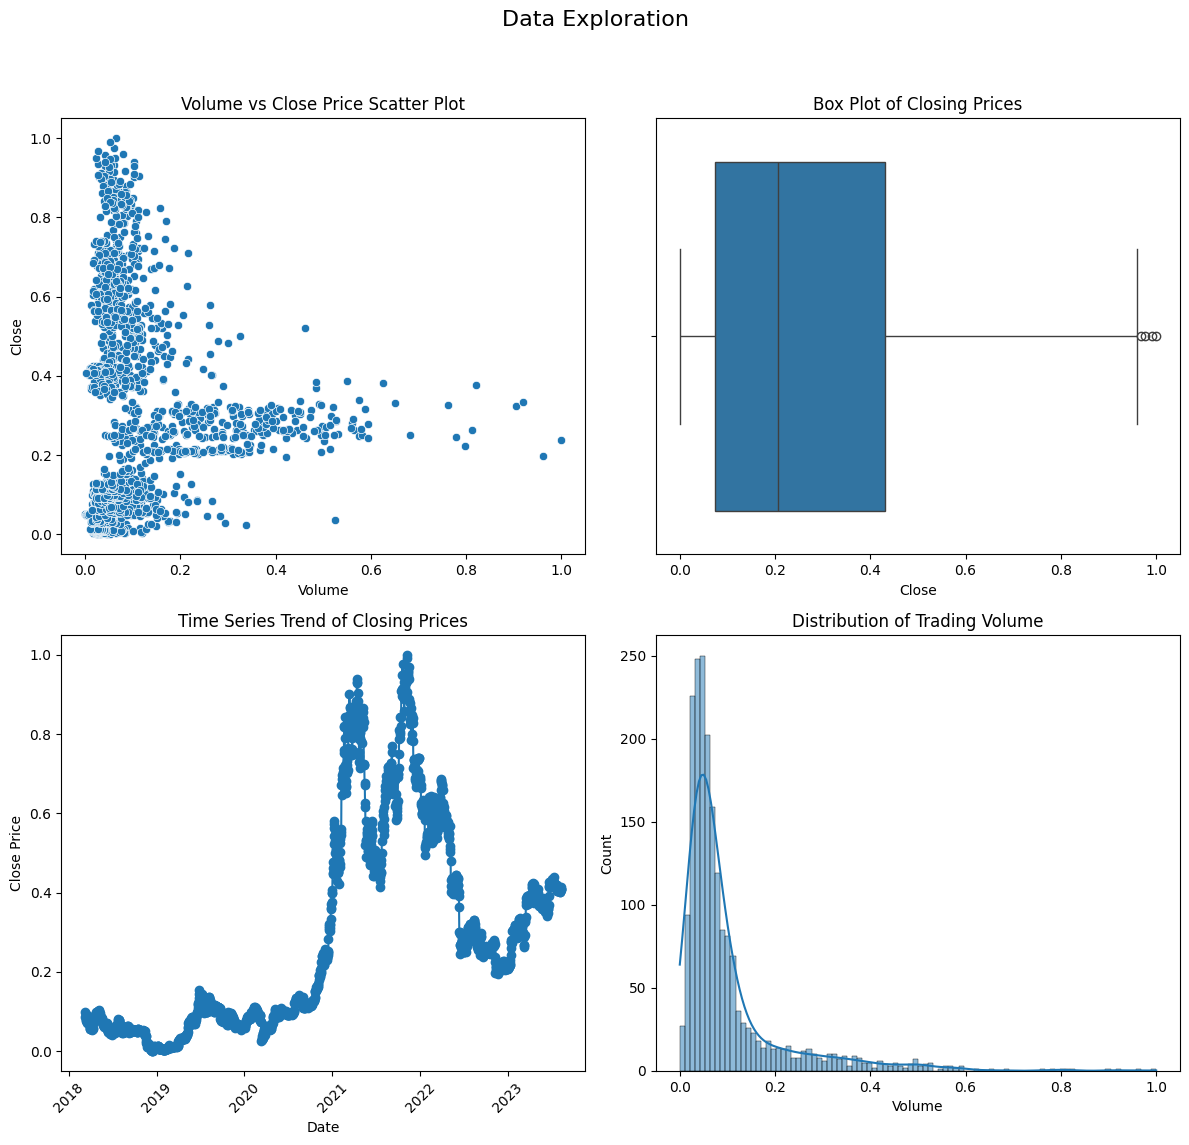

In [2]:
def load_and_explore_data(filepath):
    data = pd.read_excel(filepath)
    print("Data info:")
    print("Data description:")

    # Setting up a subplot grid with 2 rows and 2 columns
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
    fig.suptitle('Data Exploration', fontsize=16)

    # Scatter plot to explore relationships
    sns.scatterplot(x='Volume', y='Close', data=data, ax=axes[0, 0])
    axes[0, 0].set_title('Volume vs Close Price Scatter Plot')

    # Box plot for outliers
    sns.boxplot(x=data['Close'], ax=axes[0, 1])
    axes[0, 1].set_title('Box Plot of Closing Prices')

    # Time series trend of 'Close' prices
    axes[1, 0].plot(data['Open time'], data['Close'], marker='o', linestyle='-')
    axes[1, 0].set_title('Time Series Trend of Closing Prices')
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].set_ylabel('Close Price')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # Histogram for 'Volume'
    sns.histplot(data['Volume'], kde=True, ax=axes[1, 1])
    axes[1, 1].set_title('Distribution of Trading Volume')

    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    return data

# Path to the data file
filepath = 'BTCUSDT_1d_data_Regression Processed.xlsx'
data = load_and_explore_data(filepath)


C:\Users\Abdien\AppData\Local\Temp\ipykernel_10404\607660483.py:47: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = axes[2, 1].scatter(data['Volume'], data['Close'], s=bubble_size, alpha=0.5, cmap='viridis', edgecolors='w', linewidths=0.5)


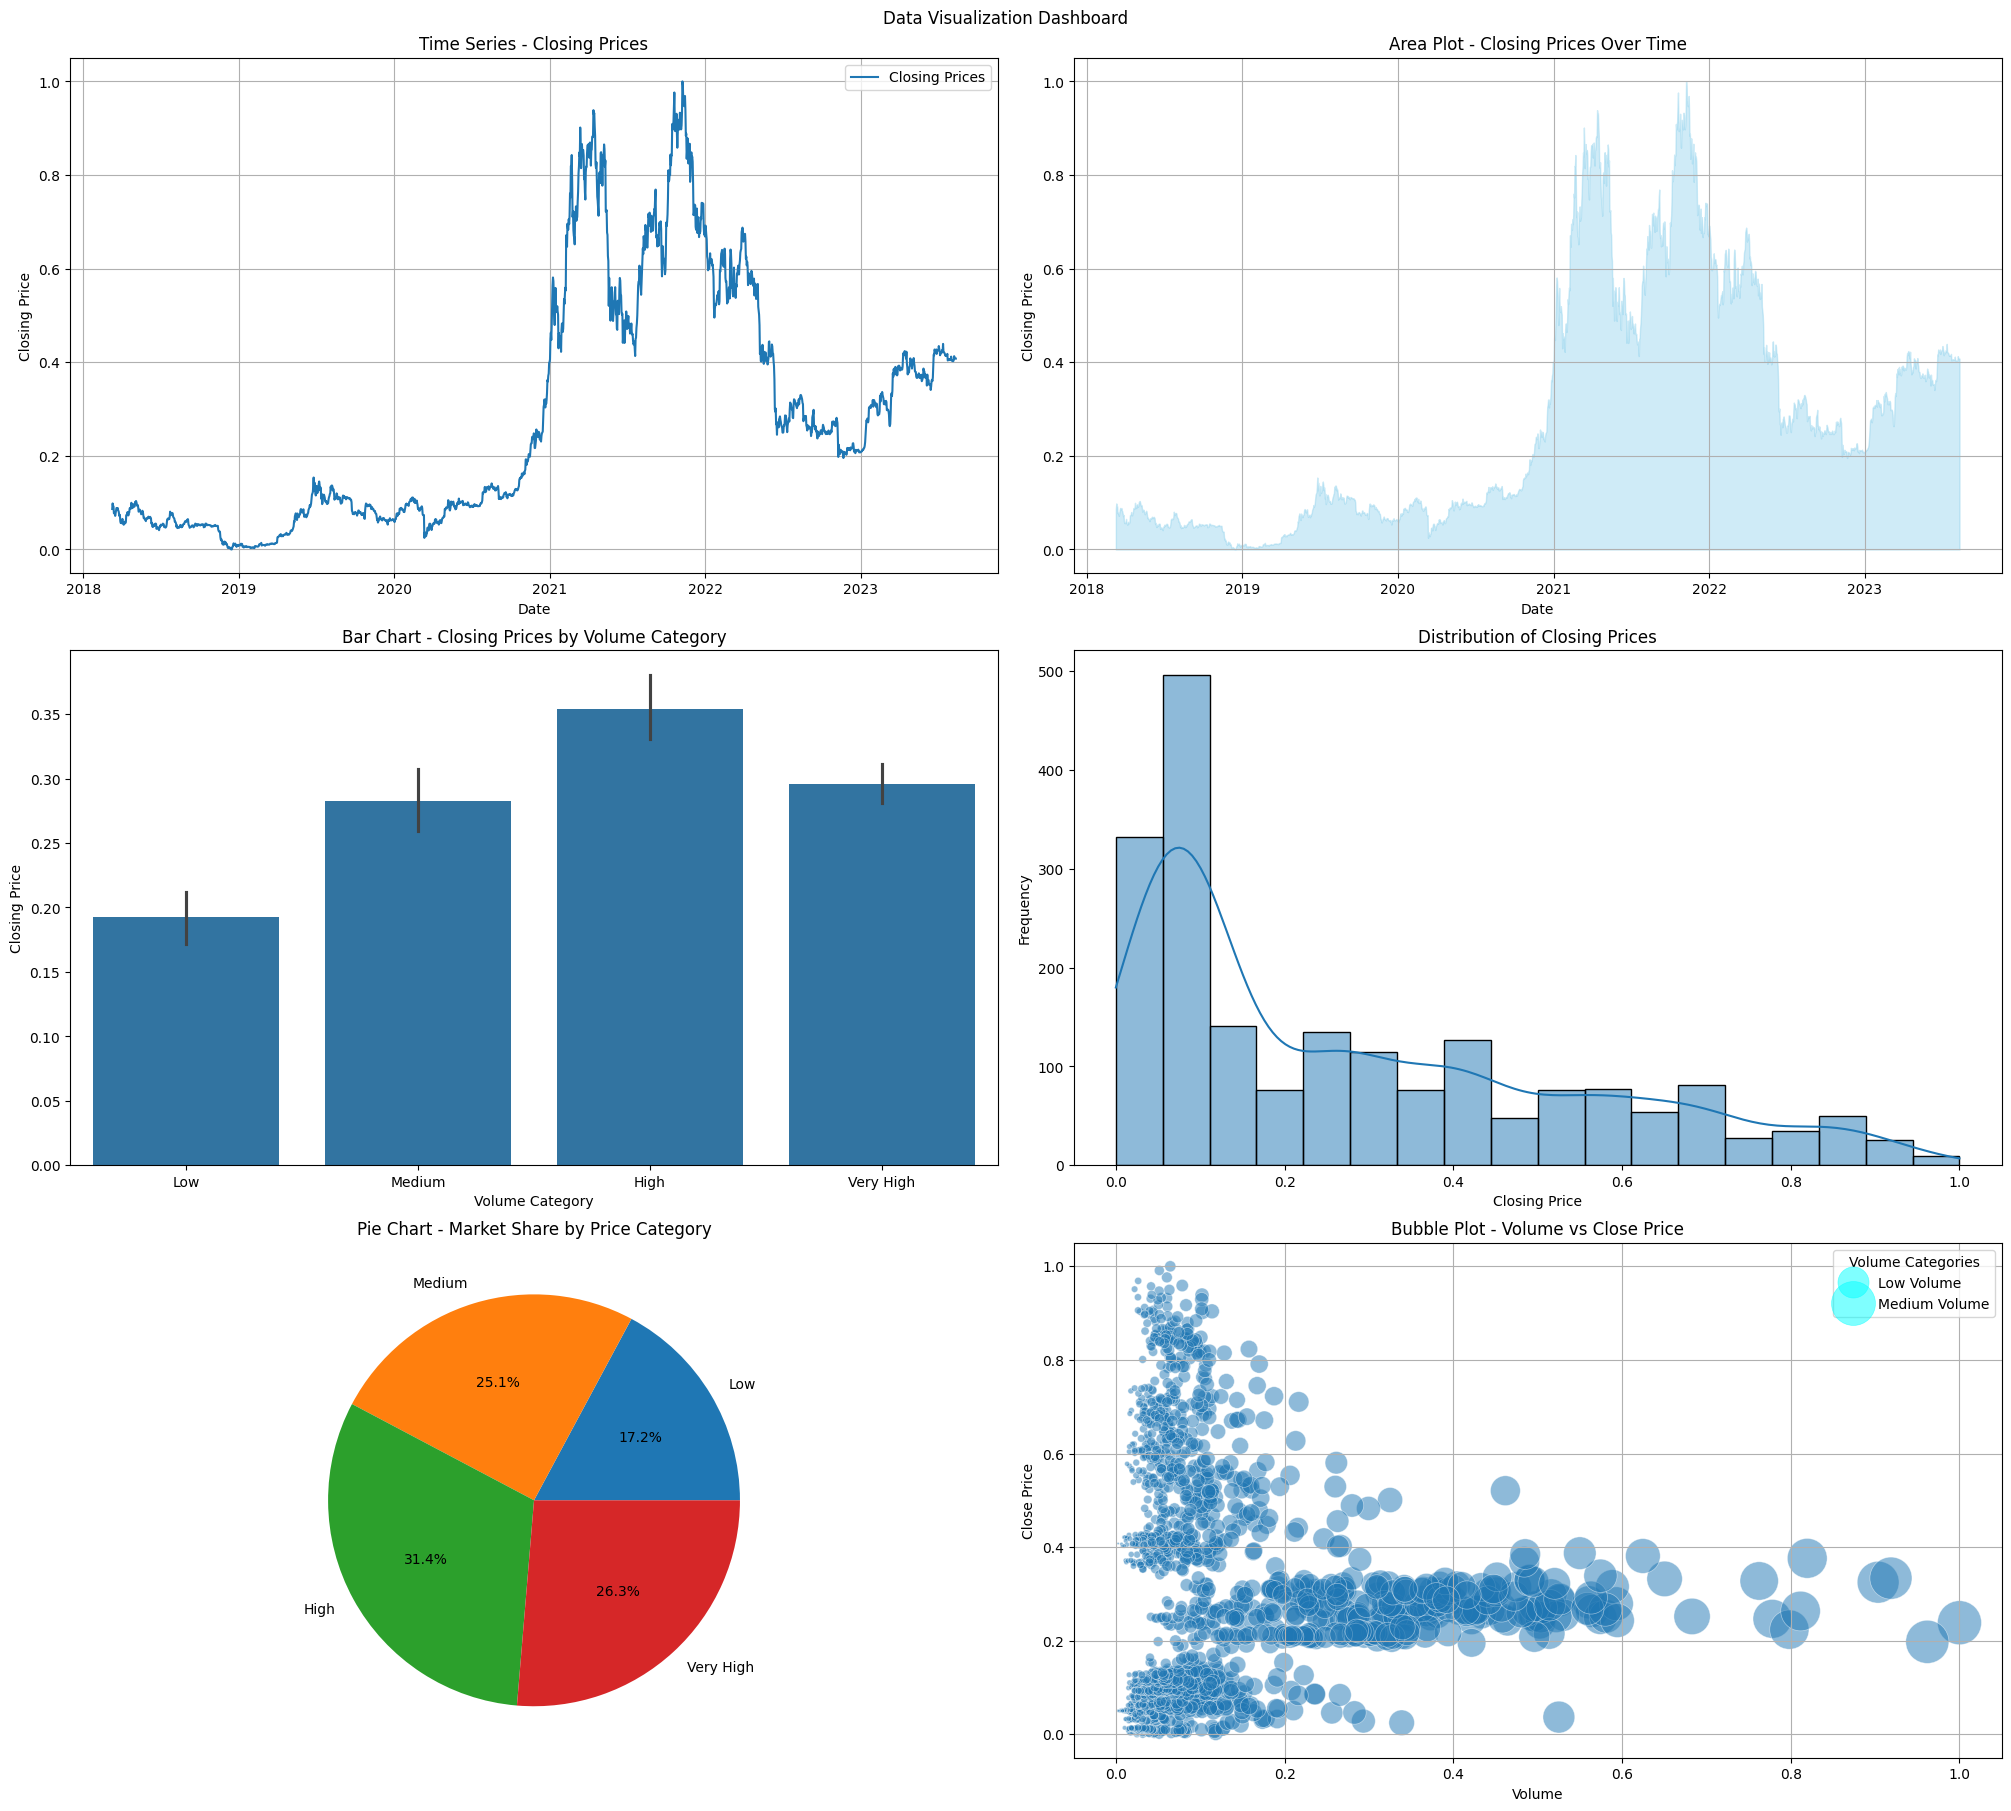

In [3]:

def visualize_data_dashboard(data):
    
    
    # Prepare category data for bar and pie plots
    if 'Category' not in data.columns:
        data['Category'] = pd.qcut(data['Volume'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

    # Set up the figure for subplots
    fig, axes = plt.subplots(3, 2, figsize=(20, 18), constrained_layout=True)
    fig.suptitle('Data Visualization Dashboard')

    # Line Plot
    axes[0, 0].plot(data['Open time'], data['Close'], label='Closing Prices')
    axes[0, 0].set_title('Time Series - Closing Prices')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Closing Price')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Area Plot
    axes[0, 1].fill_between(data['Open time'], data['Close'], color="skyblue", alpha=0.4)
    axes[0, 1].set_title('Area Plot - Closing Prices Over Time')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('Closing Price')
    axes[0, 1].grid(True)

    # Bar Chart
    sns.barplot(x='Category', y='Close', data=data, ax=axes[1, 0])
    axes[1, 0].set_title('Bar Chart - Closing Prices by Volume Category')
    axes[1, 0].set_xlabel('Volume Category')
    axes[1, 0].set_ylabel('Closing Price')

    # Distribution Plot
    sns.histplot(data['Close'], kde=True, ax=axes[1, 1])
    axes[1, 1].set_title('Distribution of Closing Prices')
    axes[1, 1].set_xlabel('Closing Price')
    axes[1, 1].set_ylabel('Frequency')

    # Pie Chart
    result = data.groupby('Category')['Close'].sum()
    result.plot(kind='pie', autopct='%1.1f%%', ax=axes[2, 0])
    axes[2, 0].set_title('Pie Chart - Market Share by Price Category')
    axes[2, 0].set_ylabel('')  # Hide the y-label

    # Bubble Plot
    bubble_size = data['Volume'] / data['Volume'].max() * 1000  # Normalize size
    scatter = axes[2, 1].scatter(data['Volume'], data['Close'], s=bubble_size, alpha=0.5, cmap='viridis', edgecolors='w', linewidths=0.5)
    axes[2, 1].set_title('Bubble Plot - Volume vs Close Price')
    axes[2, 1].set_xlabel('Volume')
    axes[2, 1].set_ylabel('Close Price')
    axes[2, 1].grid(True)
    handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5, num=3, color='cyan')
    axes[2, 1].legend(handles, ['Low Volume', 'Medium Volume', 'High Volume'], title="Volume Categories")

    plt.show()
    data.drop(columns=['Category'], inplace=True)
# Path to the data file
visualize_data_dashboard(data)


## Data Cleaning  

In [4]:
def clean_data(data):
    """
    Clean the dataset by filling missing values, removing duplicates, and handling outliers.
    Args:
        data (pd.DataFrame): The data to clean.
    Returns:
        pd.DataFrame: The cleaned data.
    """
    # Fill numerical missing values with the median
    for column in data.select_dtypes(include=['float64', 'int64']):
        median = data[column].median()
        data[column].fillna(median, inplace=True)
    
    # Fill categorical missing values with the mode
    for column in data.select_dtypes(include=['object']):
        mode = data[column].mode()[0]
        data[column].fillna(mode, inplace=True)
    
    print("Data after filling missing values:\n", data.head())

    # Remove duplicates
    initial_count = len(data)
    data.drop_duplicates(inplace=True)
    print(f"Removed {initial_count - len(data)} duplicates")

    # Handle outliers using IQR
    for column in data.select_dtypes(include=['float64', 'int64']):
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data[column] = np.where(data[column] < lower_bound, lower_bound, data[column])
        data[column] = np.where(data[column] > upper_bound, upper_bound, data[column])
    
    print("Data after handling outliers:\n", data.head())

    return data

clean_data(data)

Data after filling missing values:
    Open time      Open      High       Low     Close    Volume  \
0 2018-03-10  0.093577  0.094540  0.087381  0.086427  0.041639   
1 2018-03-11  0.086428  0.098344  0.083939  0.098296  0.051105   
2 2018-03-12  0.098297  0.100609  0.089172  0.092042  0.048329   
3 2018-03-13  0.092042  0.094297  0.089854  0.092332  0.045628   
4 2018-03-14  0.092362  0.092163  0.075223  0.077095  0.058234   

   Quote asset volume  Number of trades  Taker buy base asset volume  \
0            0.017438          0.014906                     0.040079   
1            0.021012          0.017894                     0.049514   
2            0.020557          0.018110                     0.044729   
3            0.018938          0.018512                     0.046037   
4            0.022307          0.022231                     0.054173   

   Taker buy quote asset volume  ...  MACD_Histogram  Upper_Band  Middle_Band  \
0                      0.016458  ...        0.500901 

,Open time,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,...,MACD_Histogram,Upper_Band,Middle_Band,Lower_Band,%K,%D,Stoch_Oversold,Stoch_Overbought,%K_%D_Crossover,OBV
0,2018-03-10,0.093577,0.094540,0.087381,0.086427,0.041639,0.017438,0.014906,0.040079,0.016458,...,0.500901,0.127646,0.115382,0.104561,0.140546,0.186622,0.0,0.0,0.0,0.444499
1,2018-03-11,0.086428,0.098344,0.083939,0.098296,0.051105,0.021012,0.017894,0.049514,0.019983,...,0.507036,0.126381,0.114023,0.103144,0.237738,0.164367,0.0,0.0,1.0,0.449422
2,2018-03-12,0.098297,0.100609,0.089172,0.092042,0.048329,0.020557,0.018110,0.044729,0.018678,...,0.505643,0.125102,0.112287,0.100939,0.227789,0.178901,0.0,0.0,1.0,0.444732
3,2018-03-13,0.092042,0.094297,0.089854,0.092332,0.045628,0.018938,0.018512,0.046037,0.018687,...,0.508614,0.124998,0.111207,0.098762,0.267286,0.223382,0.0,0.0,1.0,0.449196
4,2018-03-14,0.092362,0.092163,0.075223,0.077095,0.058234,0.022307,0.022231,0.054173,0.020377,...,0.493275,0.126861,0.109830,0.093665,0.166906,0.198523,0.0,0.0,0.0,0.443675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1977,2023-08-08,0.404256,0.410317,0.412110,0.412953,0.052925,0.075490,0.053761,0.057684,0.079674,...,0.573845,0.404242,0.434665,0.461664,0.491578,0.359648,0.0,0.0,1.0,0.301661
1978,2023-08-09,0.412953,0.409039,0.415761,0.410023,0.042731,0.062721,0.045390,0.042931,0.061455,...,0.580182,0.403747,0.434482,0.461851,0.586063,0.462790,0.0,0.0,1.0,0.297440
1979,2023-08-10,0.410023,0.402619,0.414865,0.408060,0.023471,0.037616,0.029788,0.022781,0.035724,...,0.581333,0.402683,0.434108,0.462294,0.620122,0.562044,0.0,0.0,1.0,0.294834
1980,2023-08-11,0.408061,0.399979,0.413791,0.407598,0.019727,0.032699,0.024784,0.019018,0.030884,...,0.581179,0.401863,0.433799,0.462592,0.547099,0.581530,0.0,0.0,0.0,0.292542


## Data Analysis

Strong Correlations with 'Close':
High                            0.999182
Low                             0.999003
Open                            0.998200
EMA_12                          0.995350
Middle_Band                     0.988318
EMA_26                          0.988262
Upper_Band                      0.985876
Lower_Band                      0.978824
EMA_50                          0.974544
SMA_50                          0.966881
SMA_100                         0.921111
SMA_200                         0.849295
OBV                             0.658484
Quote asset volume              0.548305
Taker buy quote asset volume    0.546528
Name: Close, dtype: float64

Weak Correlations with 'Close':
Number of trades               0.408504
Signal_Line                    0.191044
MACD                           0.171508
Volume                         0.090695
Taker buy base asset volume    0.081835
%D                             0.078797
RSI                            0.078576
%K        

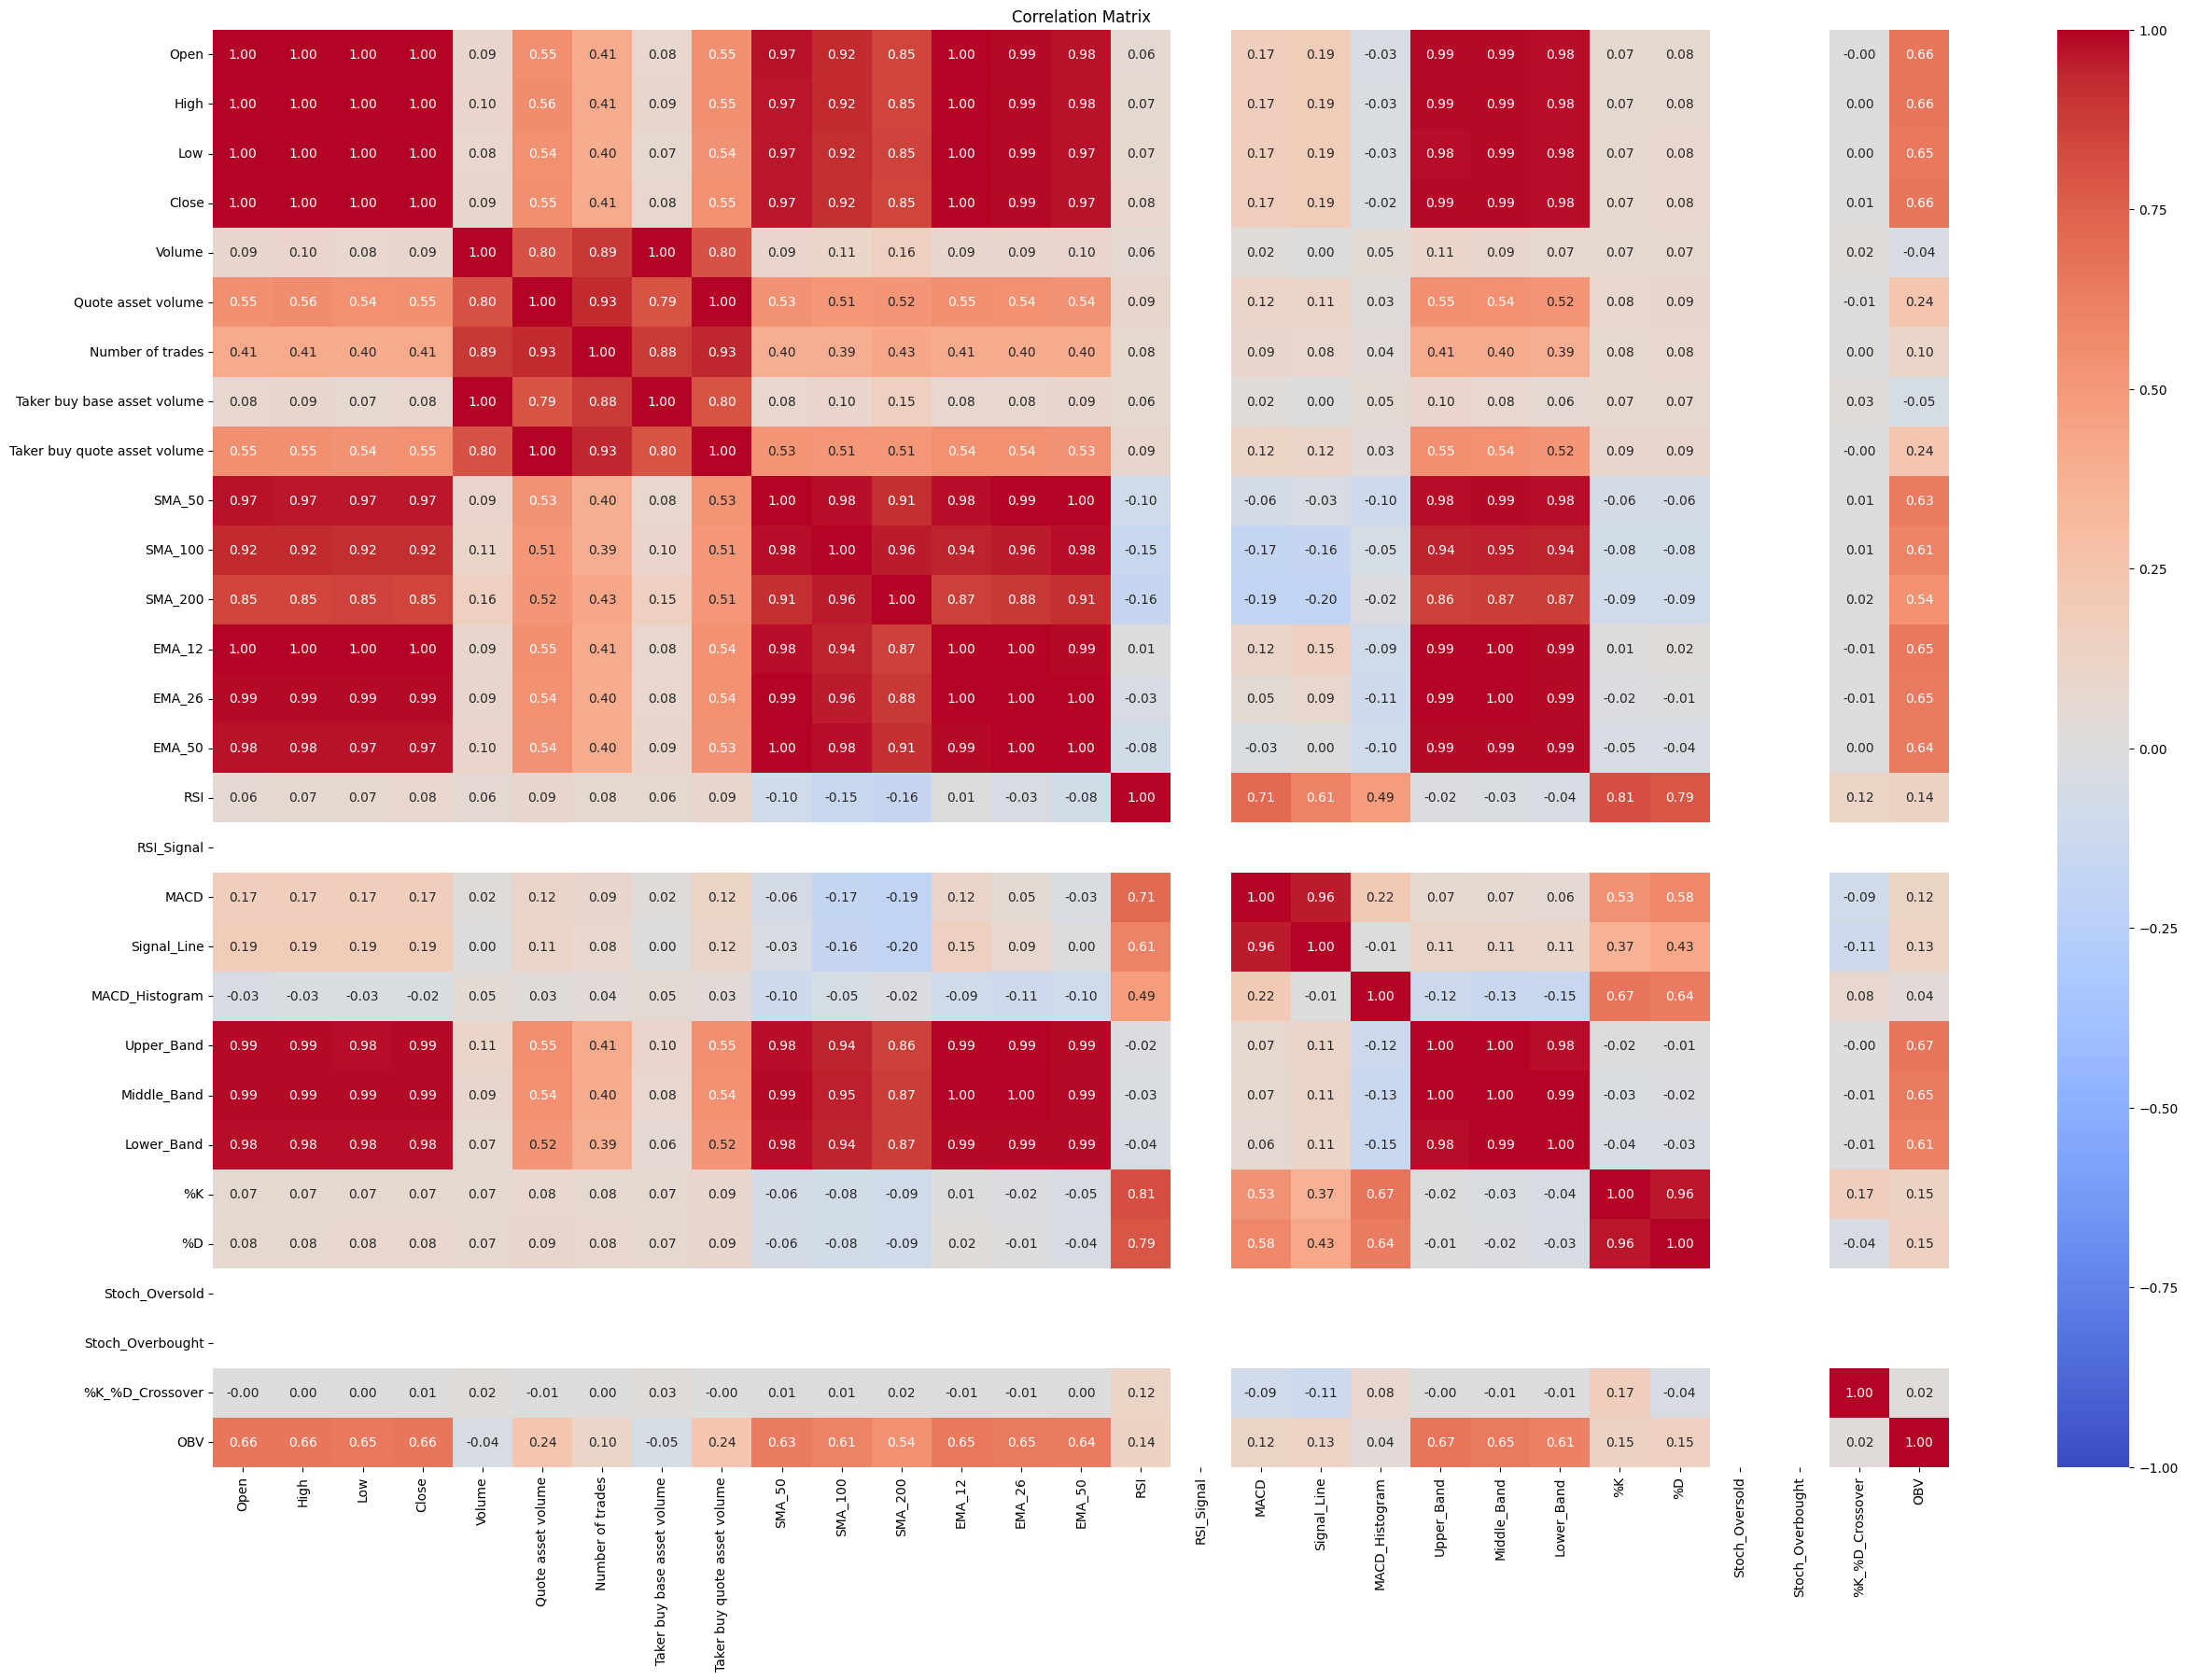

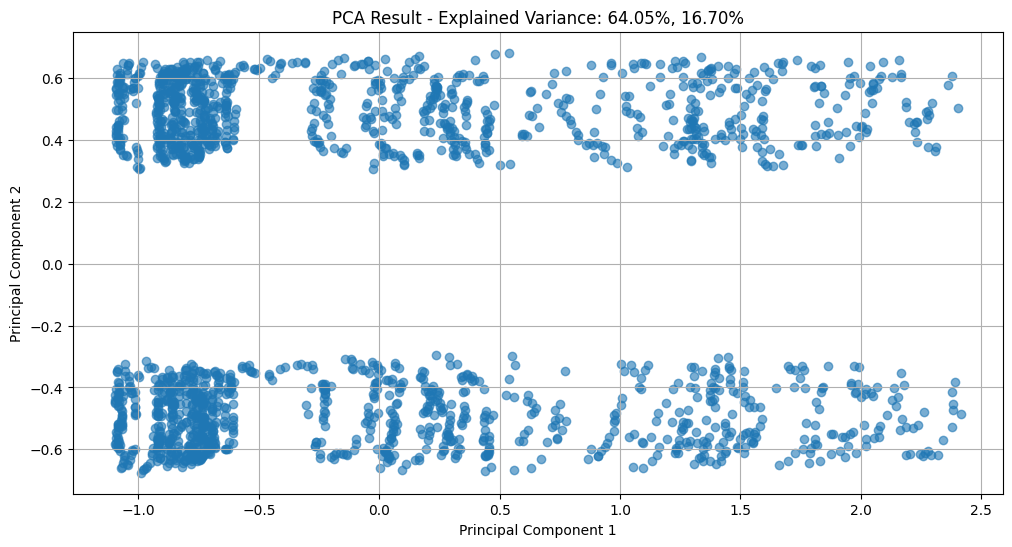

In [5]:
def analyze_correlations(data, columns=None, strong_threshold=0.5, weak_threshold=0.5, visualize_pca=True):
    """
    Analyze and visualize correlations between numeric features and perform PCA if specified.
    Args:
        data (pd.DataFrame): The dataset containing the features.
        columns (list, optional): List of columns to include in the correlation matrix. Defaults to None.
        strong_threshold (float, optional): Threshold for considering correlations as strong. Defaults to 0.5.
        weak_threshold (float, optional): Threshold for considering correlations as weak. Defaults to 0.5.
        visualize_pca (bool, optional): Whether to perform and visualize PCA analysis. Defaults to True.
    """
    # Ensure only numeric data is used
    if columns:
        data = data[columns]
    else:
        # Filter out non-numeric columns
        data = data.select_dtypes(include=[np.number])

    correlation_matrix = data.corr()

    # Identify strong and weak correlations with 'Close'
    if 'Close' in correlation_matrix:
        close_correlations = correlation_matrix['Close']
        strong_correlations = close_correlations[close_correlations.abs() >= strong_threshold].drop('Close', errors='ignore')
        weak_correlations = close_correlations[close_correlations.abs() < weak_threshold].drop('Close', errors='ignore')

        print("Strong Correlations with 'Close':")
        print(strong_correlations.sort_values(ascending=False, ignore_index=False))
        print("\nWeak Correlations with 'Close':")
        print(weak_correlations.sort_values(ascending=False, ignore_index=False))

    # Plot the correlation matrix heatmap
    plt.figure(figsize=(30, 20))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, center=0)
    plt.title('Correlation Matrix')
    plt.show()

    # PCA Analysis for variable importance if required
    if visualize_pca and not data.dropna().empty:
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(data.dropna())
        explained_variance = pca.explained_variance_ratio_
        
        plt.figure(figsize=(12, 6))
        plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6)
        plt.title('PCA Result - Explained Variance: {:.2%}, {:.2%}'.format(*explained_variance))
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.grid(True)
        plt.show()


analyze_correlations(data)


In [6]:
def select_strong_correlations(data, target_column='Close', threshold=0.5):
    """
    Select columns that have a strong correlation with the target column.
    
    Args:
    data (DataFrame): The dataset containing the features.
    target_column (str): The target column to check correlations against.
    threshold (float): Threshold for considering correlations as strong.
    
    Returns:
    DataFrame: A DataFrame containing only the columns with strong correlations to the target column.
    """
    correlation_matrix = data.corr()
    strong_correlations = correlation_matrix[target_column][correlation_matrix[target_column].abs() >= threshold]
    strong_columns = strong_correlations.index.tolist()
    print("Columns with strong correlation to '{}': {}".format(target_column, strong_columns))
    return data[strong_columns]

def split_data(data, test_size=0.2, validation_size=0.1):
    """
    Split data into training, testing, and validation sets.
    
    Args:
    data (DataFrame): The dataset to be split.
    test_size (float): The proportion of the dataset to include in the test split.
    validation_size (float): The proportion of the training dataset to include in the validation split.
    
    Returns:
    tuple: A tuple containing train, validation, and test datasets.
    """
    # First split to separate out the test set
    train_val, test = train_test_split(data, test_size=test_size, random_state=42)
    
    # Second split to separate out the validation set
    val_size_adjusted = validation_size / (1 - test_size)  # Adjust validation size
    train, val = train_test_split(train_val, test_size=val_size_adjusted, random_state=42)
    
    return train, val, test

strong_data = select_strong_correlations(data, 'Close', 0.5)
strong_data = strong_data.drop(columns=['Open time'])

train, val, test = split_data(strong_data)

print("Train set shape:", train.shape)
print("Validation set shape:", val.shape)
print("Test set shape:", test.shape)


Columns with strong correlation to 'Close': ['Open time', 'Open', 'High', 'Low', 'Close', 'Quote asset volume', 'Taker buy quote asset volume', 'SMA_50', 'SMA_100', 'SMA_200', 'EMA_12', 'EMA_26', 'EMA_50', 'Upper_Band', 'Middle_Band', 'Lower_Band', 'OBV']
Train set shape: (1386, 16)
Validation set shape: (199, 16)
Test set shape: (397, 16)


## Regression Models

Results for LinearRegression:
  MSE: 0.0000
  MAE: 0.0035
  MedAE: 0.0015
  R2: 0.9995
----------------------------------------------------------
Results for Ridge:
  MSE: 0.0001
  MAE: 0.0059
  MedAE: 0.0027
  R2: 0.9984
----------------------------------------------------------
Results for Lasso:
  MSE: 0.0652
  MAE: 0.2175
  MedAE: 0.2069
  R2: -0.0000
----------------------------------------------------------
Results for RandomForestRegressor:
  MSE: 0.0001
  MAE: 0.0049
  MedAE: 0.0019
  R2: 0.9988
----------------------------------------------------------
Results for GradientBoostingRegressor:
  MSE: 0.0001
  MAE: 0.0054
  MedAE: 0.0025
  R2: 0.9988
----------------------------------------------------------
Results for SVR:
  MSE: 0.0020
  MAE: 0.0368
  MedAE: 0.0338
  R2: 0.9693
----------------------------------------------------------
Results for KNeighborsRegressor:
  MSE: 0.0002
  MAE: 0.0078
  MedAE: 0.0030
  R2: 0.9971
------------------------------------------------------

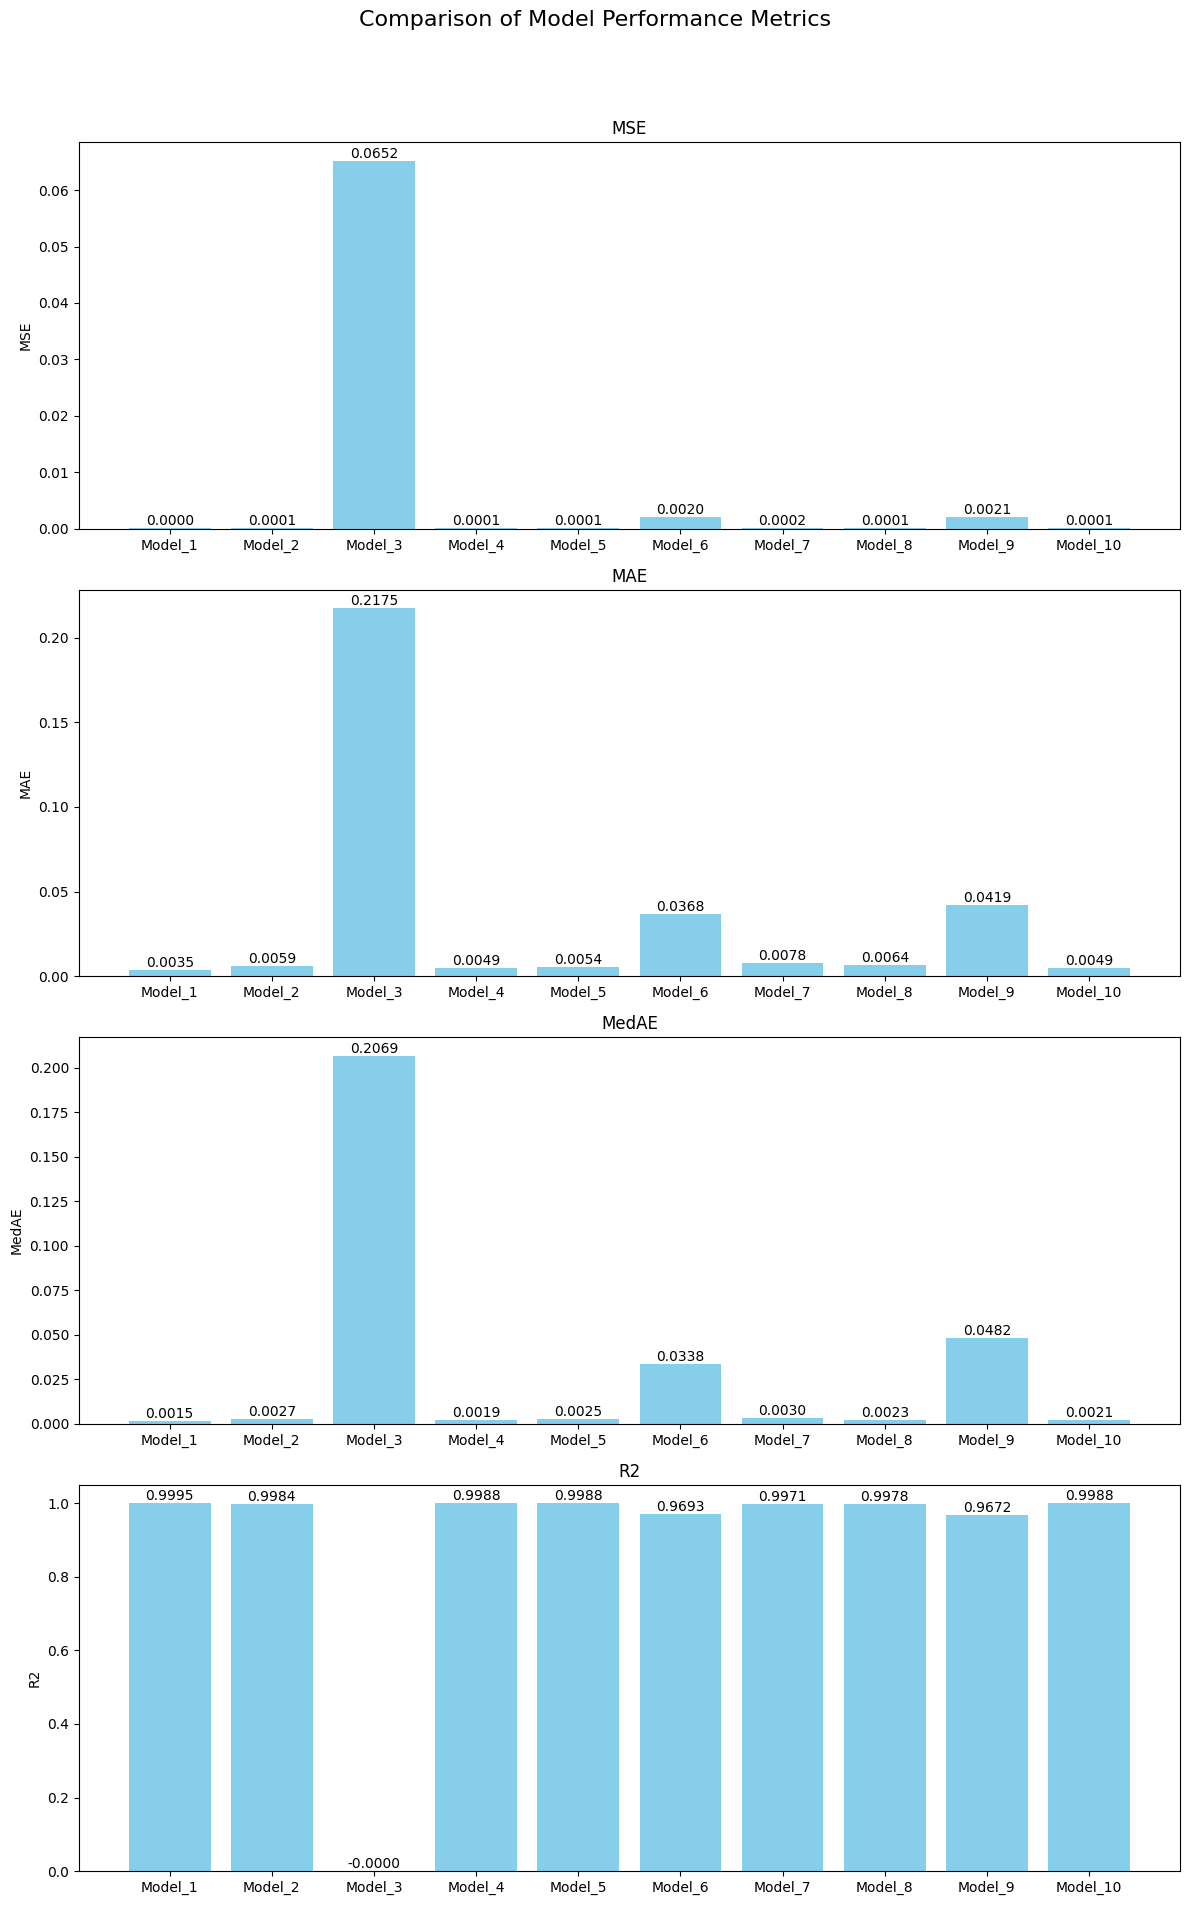

In [7]:

def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Fits a model and evaluates its performance on both the training and test sets.
    Returns evaluation metrics including MSE, MAE, MedAE, and R^2.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    medae = median_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return {'MSE': mse, 'MAE': mae, 'MedAE': medae, 'R2': r2}

# Define models to evaluate
models = [
    LinearRegression(),
    Ridge(alpha=1.0),
    Lasso(alpha=0.1),
    RandomForestRegressor(n_estimators=100),
    GradientBoostingRegressor(n_estimators=100),
    SVR(kernel='rbf'),
    KNeighborsRegressor(n_neighbors=5),
    DecisionTreeRegressor(),
    SVR(kernel='linear'),
    RandomForestRegressor(n_estimators=50)
]
target_column='Close'
# Prepare features and target for training
X_train = train.drop(target_column, axis=1)
y_train = train[target_column]
X_val = val.drop(target_column, axis=1)
y_val = val[target_column]
X_test = test.drop(target_column, axis=1)
y_test = test[target_column]
results = {}
for i, model in enumerate(models):
    result = evaluate_model(model, X_train, y_train, X_test, y_test)
    results[f'Model_{i+1}'] = result
    print(f"Results for {model.__class__.__name__}:")
    for metric, value in result.items():
        print(f"  {metric}: {value:.4f}")
    print("----------------------------------------------------------")    
# Find the best model based on R2 score
best_model = max(results, key=lambda x: results[x]['R2'])
print(f"\nBest Model: {best_model}, with R2: {results[best_model]['R2']:.4f}")

# Visualization of model performance
fig, axes = plt.subplots(4, 1, figsize=(12, 20))
fig.suptitle('Comparison of Model Performance Metrics', fontsize=16)

for i, metric in enumerate(['MSE', 'MAE', 'MedAE', 'R2']):
    values = [results[model][metric] for model in results]
    axes[i].bar(results.keys(), values, color='skyblue')
    axes[i].set_title(metric)
    axes[i].set_ylabel(metric)
    for j, value in enumerate(values):
        axes[i].text(j, value, f'{value:.4f}', ha='center', va='bottom')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Clustering Techniques

D:\anaconda\envs\grad\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for K-means with 4 clusters: 0.5543855628181451


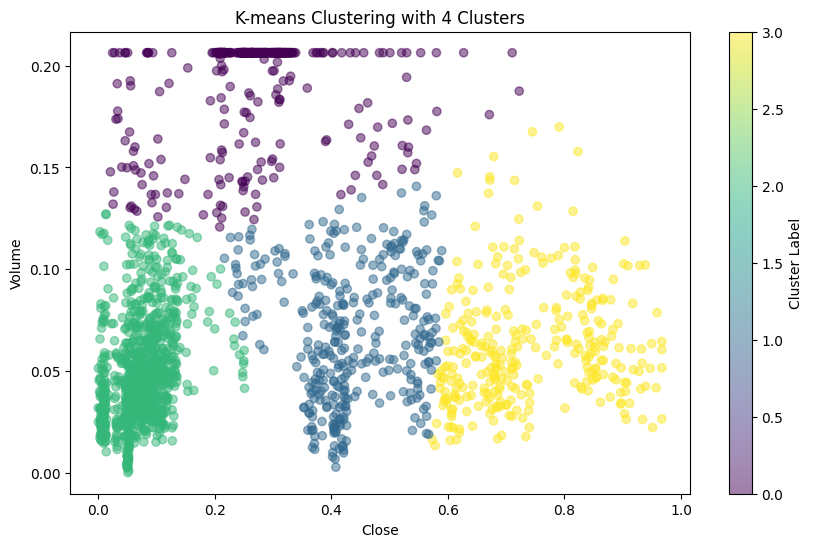

Silhouette Score for Agglomerative Clustering with ward linkage: 0.5154192401717299


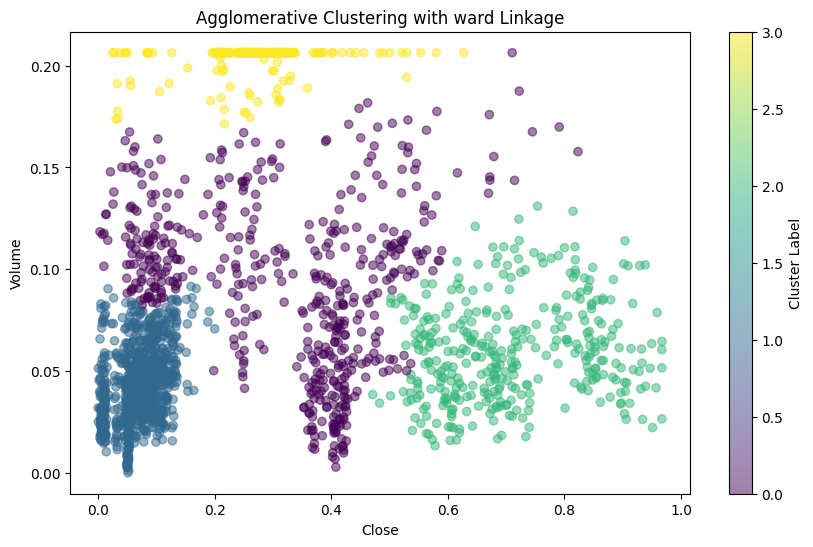

Silhouette Score for Agglomerative Clustering with average linkage: 0.5277320733158763


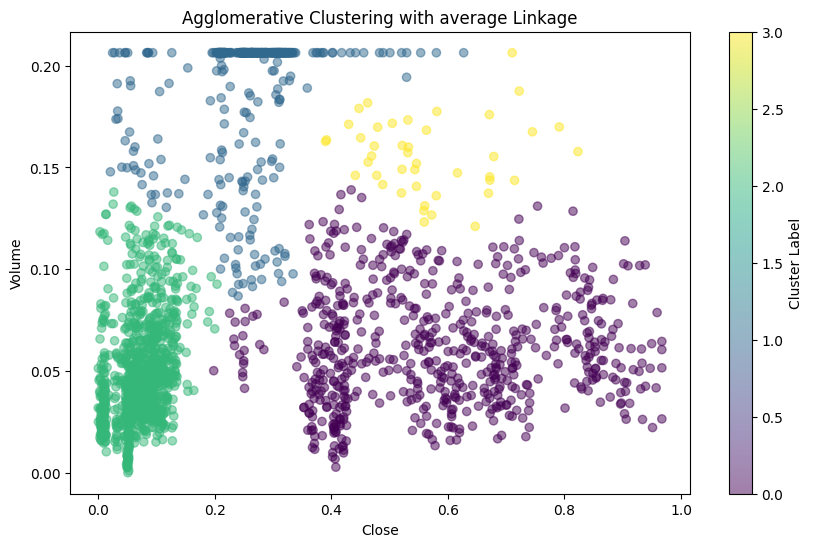

In [8]:

def perform_clustering(data, features):
    """
    Perform clustering using multiple methods (K-means and Agglomerative Clustering with 4 clusters) and evaluate using Silhouette Score.
    
    Args:
        data (DataFrame): The dataset to cluster.
        features (list): List of columns to use for clustering.
    """
    # Extract the relevant features
    data_clustering = data[features].dropna()
    
    # Standardize the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_clustering)
    
    # Dictionary to store silhouette scores
    silhouette_scores = {}

    # K-means clustering with 4 clusters
    kmeans = KMeans(n_clusters=4, random_state=42)
    labels_kmeans = kmeans.fit_predict(data_scaled)
    score_kmeans = silhouette_score(data_scaled, labels_kmeans)
    silhouette_scores['K-means 4 clusters'] = score_kmeans
    print(f"Silhouette Score for K-means with 4 clusters: {score_kmeans}")
    
    # Plotting K-means clusters
    plt.figure(figsize=(10, 6))
    plt.scatter(data_clustering.iloc[:, 0], data_clustering.iloc[:, 1], c=labels_kmeans, cmap='viridis', alpha=0.5)
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.title('K-means Clustering with 4 Clusters')
    plt.colorbar(label='Cluster Label')
    plt.show()

    # Agglomerative clustering with 4 clusters using 'ward' and 'average' linkage
    for linkage in ['ward', 'average']:
        agglom = AgglomerativeClustering(n_clusters=4, linkage=linkage)
        labels_agglom = agglom.fit_predict(data_scaled)
        score_agglom = silhouette_score(data_scaled, labels_agglom)
        silhouette_scores[f'Agglomerative {linkage} linkage'] = score_agglom
        print(f"Silhouette Score for Agglomerative Clustering with {linkage} linkage: {score_agglom}")
        
        # Plotting Agglomerative clusters
        plt.figure(figsize=(10, 6))
        plt.scatter(data_clustering.iloc[:, 0], data_clustering.iloc[:, 1], c=labels_agglom, cmap='viridis', alpha=0.5)
        plt.xlabel(features[0])
        plt.ylabel(features[1])
        plt.title(f'Agglomerative Clustering with {linkage} Linkage')
        plt.colorbar(label='Cluster Label')
        plt.show()

# Example usage
features = ['Close', 'Volume']  # Specify the features you want to use for clustering
perform_clustering(data, features)
